In [23]:
!pip install torch
!pip install torchvision
import os
import sys
import time
import math
import torch.nn.init as init

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


## Utility functions

In [46]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Building the Model

### ResNet 18 - Changing Planes - 2.9M parameters

In [47]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [48]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [49]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
device

'cuda'

## Data Processing

In [51]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..


In [52]:

ROOT = '.data'
trainset = torchvision.datasets.CIFAR10(
    root=ROOT, train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root=ROOT , train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=100, shuffle=False, num_workers=2)
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples
print(n_train_examples)
print(n_valid_examples)
generator=torch.Generator().manual_seed(42)

train_data, valid_data = torch.utils.data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples], generator = generator)

Files already downloaded and verified
Files already downloaded and verified
45000
5000


In [53]:
import copy
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = transform_test

In [54]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 256, shuffle = True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 256, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 256, shuffle = False, num_workers=2)

In [55]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [56]:
print('==> Building model..')
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


==> Building model..


## Counting Parameters

In [57]:
print("Number of trainable parameters: ",count_parameters(net))

Number of trainable parameters:  2929866


In [72]:
# displaying the architecture of the model to see how the input and output planes align 

net

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [64]:
lr = 0.001

In [65]:
# experimenting with both optimizers - Adam, SGD

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
# optimizer = optim.SGD(net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [66]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [67]:
def train(net, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    net.train()
    for (inputs, y) in iterator:
        inputs = inputs.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        
        y_pred = net(inputs)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [68]:
def evaluate(net, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    net.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = net(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Model 1 - 50 epochs, SGD optimizer, lr = 0.001

In [20]:
EPOCHS = 50
train_loss_history = []
val_loss_history = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
  train_epoch_loss , train_epoch_acc = train(net, trainloader, optimizer, criterion, device)
  val_epoch_loss , val_epoch_acc = evaluate(net, validloader, criterion, device)

  print("Epoch", epoch)
  print("Train loss & accuracy", train_epoch_loss , train_epoch_acc)
  train_loss_history.append(train_epoch_loss)
  train_accuracies.append(train_epoch_acc)

  print("Validation loss & accuracy", val_epoch_loss , val_epoch_acc)
  val_loss_history.append(val_epoch_loss)
  val_accuracies.append(val_epoch_acc)

PATH = './saved_models/planes1.pt'
torch.save(net, PATH)

Epoch 0
Train loss & accuracy 1.8601097898049788 0.3045037287202748
Validation loss & accuracy 1.5772459924221038 0.41313189417123797
Epoch 1
Train loss & accuracy 1.485608382658525 0.44992720166390593
Validation loss & accuracy 1.4451650142669679 0.4833524823188782
Epoch 2
Train loss & accuracy 1.3042200316082349 0.5247238989580761
Validation loss & accuracy 1.2772607445716857 0.5447495400905609
Epoch 3
Train loss & accuracy 1.163966893133792 0.5799680396237157
Validation loss & accuracy 1.1369553923606872 0.5966222435235977
Epoch 4
Train loss & accuracy 1.0623728212985126 0.6145756390284408
Validation loss & accuracy 1.0518992334604262 0.6272633284330368
Epoch 5
Train loss & accuracy 0.9791627817533233 0.6496049358763478
Validation loss & accuracy 1.0416016459465027 0.6244715064764023
Epoch 6
Train loss & accuracy 0.9110643856904723 0.672977627678351
Validation loss & accuracy 1.0155232161283494 0.6454963237047195
Epoch 7
Train loss & accuracy 0.8628696023740552 0.6936283734711733
Va

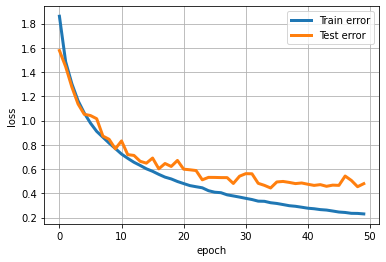

In [21]:
# loss curves
# lr = 0.001, SGD, 50 epochs, 64-64-128-256, no MaxPool, 2.9M parameters

plt.plot(range(50),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(50),val_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

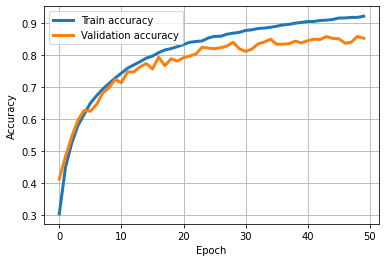

In [22]:
# accuracy curves
# lr = 0.001, SGD, 50 epochs, 64-64-128-256, no MaxPool, 2.9M parameters

plt.plot(range(50), train_accuracies,'-', linewidth=3, label='Train accuracy')
plt.plot(range(50), val_accuracies,'-', linewidth=3, label='Validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [77]:
net1 = torch.load('./saved_models/planes1.pt')

In [78]:
# TESTING

test_loss_epoch, test_acc = evaluate(net1, testloader,criterion, device)
print(test_loss_epoch)
print(test_acc)

0.5066149264574051
0.84814453125


## Model - 50 epochs, Adam Optimizer,  lr = 0.001

In [69]:
EPOCHS = 50
train_loss_history = []
val_loss_history = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
  train_epoch_loss , train_epoch_acc = train(net, trainloader, optimizer, criterion, device)
  val_epoch_loss , val_epoch_acc = evaluate(net, validloader, criterion, device)

  print("Epoch", epoch)
  print("Train loss & accuracy", train_epoch_loss , train_epoch_acc)
  train_loss_history.append(train_epoch_loss)
  train_accuracies.append(train_epoch_acc)

  print("Validation loss & accuracy", val_epoch_loss , val_epoch_acc)
  val_loss_history.append(val_epoch_loss)
  val_accuracies.append(val_epoch_acc)

PATH = './saved_models/planes1-adam.pt'
torch.save(net, PATH)

Epoch 0
Train loss & accuracy 1.4617348821325735 0.45822798291390593
Validation loss & accuracy 1.3021703124046327 0.5392233461141587
Epoch 1
Train loss & accuracy 0.9856503409418192 0.6454350142316385
Validation loss & accuracy 0.9375302702188492 0.6678768396377563
Epoch 2
Train loss & accuracy 0.7739540578966791 0.7259978692639958
Validation loss & accuracy 0.9116018533706665 0.7019761025905609
Epoch 3
Train loss & accuracy 0.6515633827922019 0.7707723721184514
Validation loss & accuracy 0.696818208694458 0.7629825383424759
Epoch 4
Train loss & accuracy 0.5708132362501188 0.7999467328190804
Validation loss & accuracy 0.6524815499782562 0.7817555159330368
Epoch 5
Train loss & accuracy 0.5114285896786235 0.8230131390419874
Validation loss & accuracy 0.5748602882027626 0.8073874086141586
Epoch 6
Train loss & accuracy 0.4624841365624558 0.8397771661931818
Validation loss & accuracy 0.6627177864313125 0.7825482547283172
Epoch 7
Train loss & accuracy 0.42878447557714855 0.8510937497697093


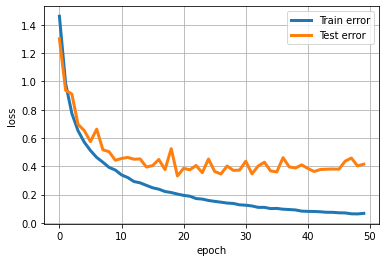

In [70]:
# loss curves
# lr = 0.001, Adam, 50 epochs, 64-64-128-256, no MaxPool, 2.9M parameters

plt.plot(range(50),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(50),val_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

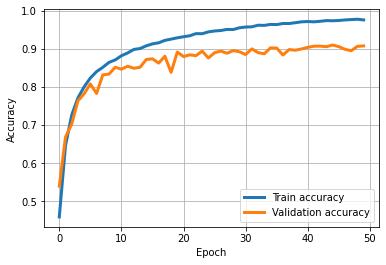

In [71]:
# accuracy curves
# lr = 0.001, Adam, 50 epochs, 64-64-128-256, no MaxPool, 2.9M parameters

plt.plot(range(50), train_accuracies,'-', linewidth=3, label='Train accuracy')
plt.plot(range(50), val_accuracies,'-', linewidth=3, label='Validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [73]:
# TESTING

test_loss_epoch, test_acc = evaluate(net, testloader,criterion, device)
print(test_loss_epoch)
print(test_acc)

0.4432282768189907
0.89912109375
